In [1]:
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.utils.general_utils import *
from src.utils.train_utils import *
from src.data.some_dataloader import RedditDataset

## A first glance at the data

In [2]:
dataset = RedditDataset()
body = dataset.data_body
title = dataset.data_title

* Most negative subreddits

Using 71 subreddits (>400 posts)


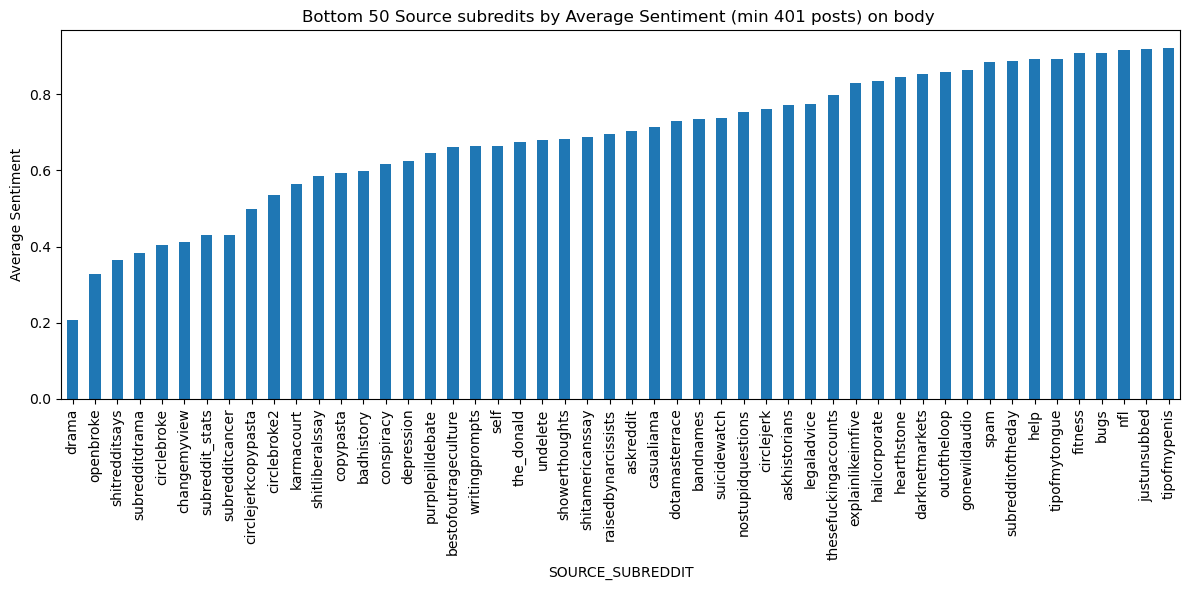

In [3]:
plot_sorted_subreddits(
    get_sorted_subreddits_by_avg_sentiment(body, 'SOURCE_SUBREDDIT',min_count=400, ascending=True),
    50,
    'SOURCE_SUBREDDIT',
    'Bottom 50 Source subredits by Average Sentiment (min 401 posts) on body '
    )

* Most positive subreddits

Using 71 subreddits (>400 posts)


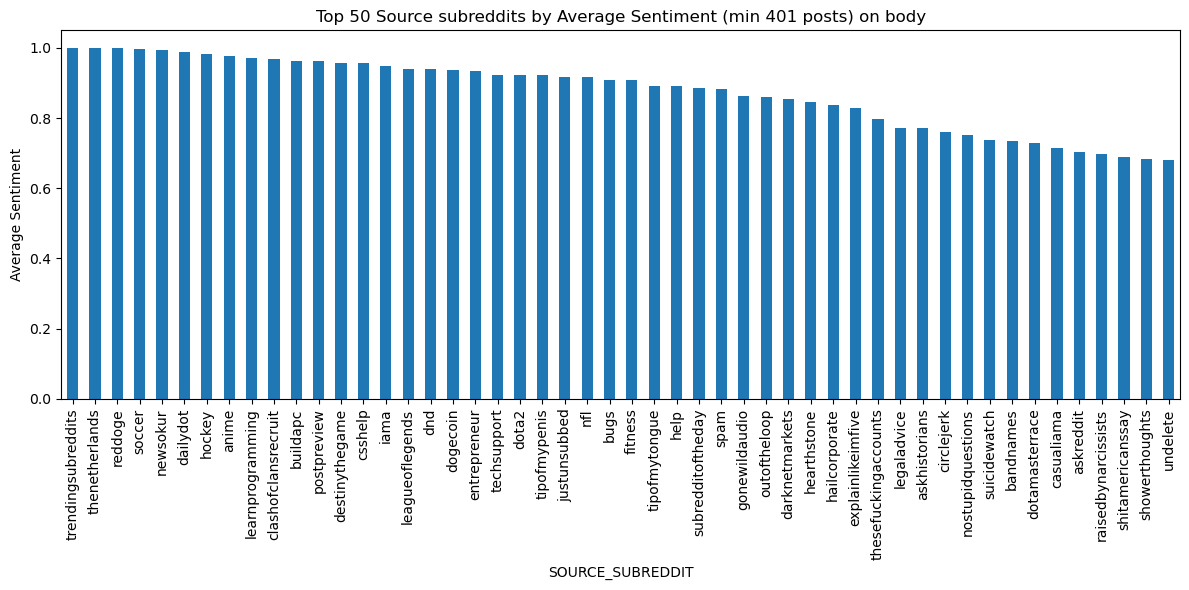

In [4]:
plot_sorted_subreddits(
    get_sorted_subreddits_by_avg_sentiment(body, 'SOURCE_SUBREDDIT',min_count=400 ,ascending=False),
    50,
    'SOURCE_SUBREDDIT',
    'Top 50 Source subreddits by Average Sentiment (min 401 posts) on body'
    )

## html spring graph of 2 most negative outgoing subreddits
Could be used with more nodes, more filtered dataset (time window, subset of slected subreddits)

In [5]:
import importlib
from src.utils import general_utils

importlib.reload(general_utils)
from src.utils.general_utils import write_html_spring_graph_n_nodes

write_html_spring_graph_n_nodes(
    body,
    get_sorted_subreddits_by_avg_sentiment(body, direction='SOURCE_SUBREDDIT',min_count=400, ascending=True),
    2
    )

Using 71 subreddits (>400 posts)


# Logistic regression model to classify link sentiment over time window
Could be use to compare the "influence" of properties over time, could be use with dataset of only selected subreddit iteraction.
Obviously we should separate the dataset into 80% training and 20% test set. An evaluation function still needs to be implemented to evaluate the model (and other model we might create).

In [ ]:
properties_test = [5, 10, 15, 20] # properties we want the logistic regression to be trained on, this is just an example with some I selected 
path_test = 'src/models/properties_logitreg_test.pkl' 
train_logit_link_sentiment_timewindow(body, properties_test, path_test, '2016-01-01', '2017-01-01') # over 2016

Model saved to src/models/properties_logitreg_test.pkl
                           Logit Regression Results                           
Dep. Variable:         LINK_SENTIMENT   No. Observations:                   48
Model:                          Logit   Df Residuals:                       43
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.1785
Time:                        13:02:56   Log-Likelihood:                -11.310
converged:                       True   LL-Null:                       -13.768
Covariance Type:            nonrobust   LLR p-value:                    0.2960
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0551      1.596     -0.035      0.972      -3.183       3.073
prop_5        76.8620     49.687      1.547      0.122     -20.522     174.2